In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import threading
import concurrent.futures
import time
import multiprocessing as mp
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

import cv2

# mp.set_start_method('spawn') ## fork

In [2]:
train_dir = r'../Facial_Emotion_Recognition/train/train/'
test_dir = r'../Facial_Emotion_Recognition/test/test/'

In [3]:
def load_images(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for filename in os.listdir(label_dir):
                if filename.endswith('.jpg') or filename.endswith('.png'):
                    image_path = os.path.join(label_dir, filename)
                    if '\\' in image_path:
                        image_paths.append(image_path.replace('\\', '/'))
                    else:
                        image_paths.append(image_path)
                    labels.append(label)
            print(label, 'Success')
    return image_paths, labels

In [4]:
## convert to Dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_images(train_dir)
## shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

angry Success
disgust Success
fear Success
happy Success
neutral Success
sad Success
surprise Success


,image,label
0,../Facial_Emotion_Recognition/train/train/angr...,angry
1,../Facial_Emotion_Recognition/train/train/sad/...,sad
2,../Facial_Emotion_Recognition/train/train/happ...,happy
3,../Facial_Emotion_Recognition/train/train/happ...,happy
4,../Facial_Emotion_Recognition/train/train/surp...,surprise


In [5]:
## convert to Dataframe
test = pd.DataFrame()
test['image'], test['label'] = load_images(test_dir)
## shuffle the dataset
test = test.sample(frac=1).reset_index(drop=True)
test.head()

angry Success
disgust Success
fear Success
happy Success
neutral Success
sad Success
surprise Success


,image,label
0,../Facial_Emotion_Recognition/test/test/sad/Pr...,sad
1,../Facial_Emotion_Recognition/test/test/happy/...,happy
2,../Facial_Emotion_Recognition/test/test/happy/...,happy
3,../Facial_Emotion_Recognition/test/test/neutra...,neutral
4,../Facial_Emotion_Recognition/test/test/neutra...,neutral


## Exploratory Data Analysis

<AxesSubplot:xlabel='label', ylabel='count'>

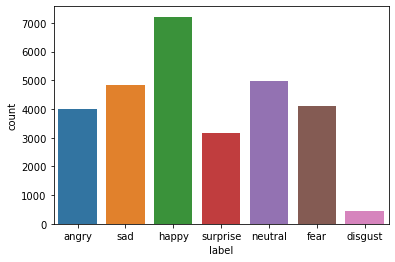

In [6]:
sns.countplot(train['label'])

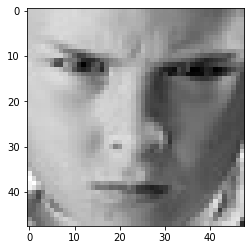

In [7]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray')

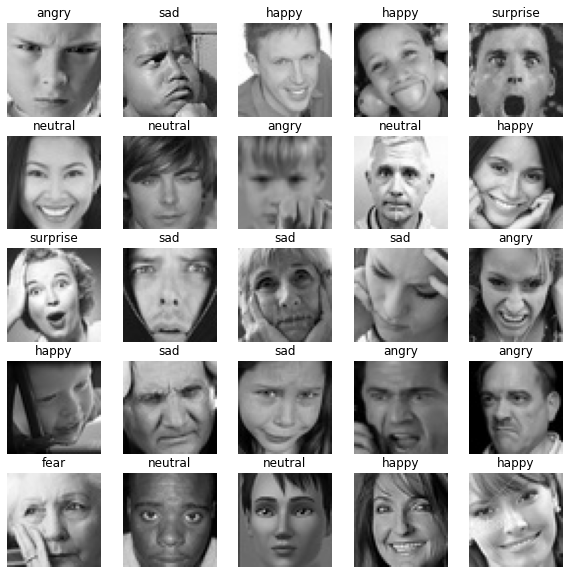

In [8]:
## to didsplay grid of images
plt.figure(figsize=(10,10))
files = train.iloc[:25]

# for tpl in files.itertuples():
#     print(tpl)

for index, row in files.iterrows():
    plt.subplot(5,5,index+1)
    img_path = row['image']
    img = cv2.imread(img_path)
    plt.imshow(img)
    plt.title(row['label'])
    plt.axis('off')

## Fuature extraction


In [9]:
def extract_features(images):
    features = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for image_path in tqdm(images):
            future = executor.submit(load_image, image_path)
            futures.append(future)
        for future in concurrent.futures.as_completed(futures):
            features.append(future.result())
    features = np.array(features)
    return features

In [10]:
def load_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (48,48))
    img = np.array(img).reshape((48,48,1))
    return img

In [11]:
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [12]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [13]:
## Normalize the images
x_train = train_features/255.0
x_test = test_features/255.0

In [14]:
## convert label to interger
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [15]:
print(y_train)
print(y_test)

[0 5 3 ... 3 1 5]
[5 3 3 ... 0 5 4]


In [16]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [17]:
y_train[0]

array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [18]:
# config
input_shape = (48,48,1)
output_class = 7

## Model Creation

In [19]:
# Define the data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(x_train)
# Create a model
model = tf.keras.models.Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    Flatten(),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(output_class, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Train the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=128),
                    epochs=5,
                    validation_data=(x_test, y_test),
                    workers=4
                    )

Epoch 1/5
225/225 [==============================] - 72s 312ms/step - loss: 1.8232 - accuracy: 0.2462 - val_loss: 1.8184 - val_accuracy: 0.2471
Epoch 2/5
225/225 [==============================] - 137s 610ms/step - loss: 1.8157 - accuracy: 0.2511 - val_loss: 1.8150 - val_accuracy: 0.2471
Epoch 3/5
225/225 [==============================] - 69s 305ms/step - loss: 1.8144 - accuracy: 0.2513 - val_loss: 1.8152 - val_accuracy: 0.2471
Epoch 4/5
225/225 [==============================] - 69s 305ms/step - loss: 1.8132 - accuracy: 0.2513 - val_loss: 1.8133 - val_accuracy: 0.2471
Epoch 5/5
225/225 [==============================] - 69s 304ms/step - loss: 1.8134 - accuracy: 0.2513 - val_loss: 1.8132 - val_accuracy: 0.2471


# Plot the Result

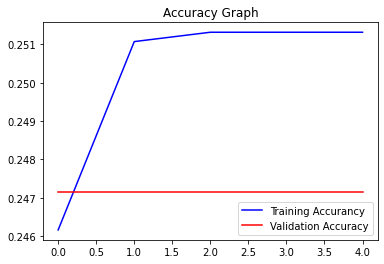

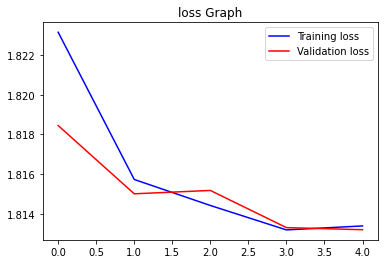

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accurancy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('loss Graph')
plt.legend()

plt.show()

## Test with Image Data

Original Output :  happy
1/1 [==============================] - 0s 22ms/step
Predicted Output:  ['happy']


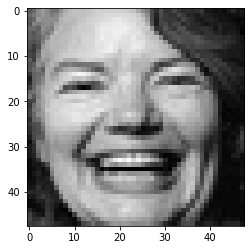

In [27]:
image_index = random.randint(0, len(test))
print('Original Output : ',test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1,48,48,1))
prediction_label = le.inverse_transform(pred.argmax().ravel())
print('Predicted Output: ',prediction_label)
plt.imshow(x_test[image_index].reshape(48,48), cmap='gray')